# Rust (1987): Harold Zurcher Problem

### Components

- **State variables**: vector of variables that describe all relevant information about the modeled decision process, $ x_t $  

- **Decision variables**: vector of variables describing the choices, $ i_t $ 

- **Paramters**: vector of parameters, $ \Theta $ 

- **Payoff**: utility function, $ u(x_t,i_t,\Theta) $, with time separable discounted utility  

- **Motion rules**: how state variable evolve through time, conditional on choices, $ x_{t+1} \sim F(x'|x_t,i_t) $

#### State

$ x_t \in \{0,10\} $

#### Decision

$ i_t = \{\text{keep}, \text{replace}\} = \{0,1\} $

#### Parameters

$ \Theta = \{RC,\theta_{11}\} $, where $ RC $ is the replacement cost and $ \theta_{11} $ is a preference parameter

#### Payoff

$$
u(x_{t},i_t,\Theta)=\left \{
\begin{array}{ll}
    -0.001*\theta_{11}*x^2 & \text{if }i_{t}=0 \\
    -RC & \text{if }i_{t}=1
\end{array} \right.
$$

#### Motion

$$
x_{t+1}\sim G(x'|x_t,i_t=0)=\left \{
\begin{array}{ll}
    \text{min}(x_t+1,10), & p=0.7 \\
    \text{min}(x_t+2,10), & p=0.3 
\end{array} \right.
$$

$$
x_{t+1}\sim G(x'|x_t,i_t=1)=0
$$

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.stats import gumbel_r, uniform
from scipy.optimize import minimize
import random

import warnings
warnings.filterwarnings('ignore')

### Value Function Iteration

In [2]:
# Parameters
beta = 0.5

RC = 3
theta11 = 60
p_x = 0.7
params = [RC, theta11]

max_x = 10
tol = 1e-9

In [3]:
# Utility
def c(x, params):
    return -0.001 * params * x**2

def u(x, i, params):
    return c((1 - i) * x, params[1]) - i * params[0] 


# Transition probability
def create_transition_matrix(max_x, p_x):
    p = p_x
    q = 1 - p
    
    matrix = np.zeros((max_x + 1, max_x + 1))
    for i in range(max_x + 1):
        
        next_state_p = min(i + 1, max_x)
        next_state_q = min(i + 2, max_x)

        matrix[i, next_state_p] += p
        if next_state_q <= max_x:
            matrix[i, next_state_q] += q
    
    return matrix


def value_function_iteration(beta, params, tol, max_x, p_x):
    V = np.zeros(max_x + 1)
    V_new = np.zeros_like(V)
    iteration = 0 
    gamma = 0.5772157
    
    p = create_transition_matrix(max_x, p_x)

    while True:
        iteration += 1
        for x in range(max_x + 1):
            V_keep = u(x, 0, params) + beta * np.dot(p[x, :], V) 
            V_replace = u(x, 1, params) + beta * V[0] 
            V_new[x] = np.log(np.exp(V_keep) + np.exp(V_replace)) + gamma * 1
        
        if np.max(np.abs(V_new - V)) < tol:
            break
        V[:] = V_new  
    
    return V

In [4]:
# Matrix
create_transition_matrix(max_x, p_x)

array([[0. , 0.7, 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.7, 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.7, 0.3, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0.3, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.7, 0.3, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.7, 0.3, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.7, 0.3, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.7, 0.3, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.7, 0.3],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

In [5]:
# VF results
VFI = value_function_iteration(beta, params, tol, max_x, p_x)
VFI

array([ 0.90908506,  0.6622591 ,  0.28098389, -0.18713446, -0.68135832,
       -1.13560278, -1.49504349, -1.7353731 , -1.8693734 , -1.93176399,
       -1.95643012])

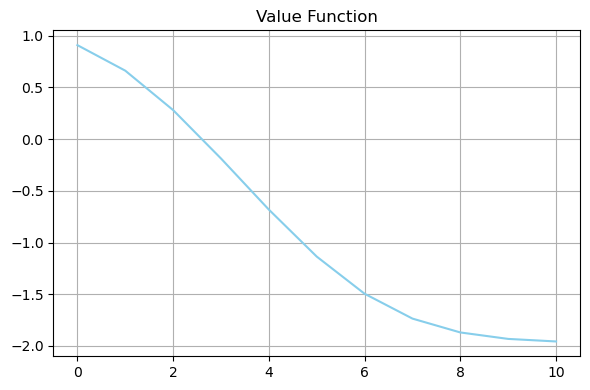

In [33]:
# Plot VF
plt.figure(figsize=(6, 4))  
plt.plot(VFI, color='skyblue')
plt.title('Value Function')
plt.tight_layout()
plt.grid(True)
plt.show()

In [7]:
# Bus Operations
N = 100000

def simulate_bus_operations(N, beta, RC, theta11, tol, max_x, p_x):
    
    params = [RC, theta11]
    transition_matrix = create_transition_matrix(max_x, p_x)
    V = value_function_iteration(beta, params, tol, max_x, p_x)  

    error0 = gumbel_r.rvs(loc=0, scale=1, size=N)
    error1 = gumbel_r.rvs(loc=0, scale=1, size=N)

    states = np.zeros(N, dtype=int)  
    decisions = np.zeros(N, dtype=int)  

    xt = 0

    for t in range(N):
        states[t] = xt
        v0 = u(xt, 0, params) + beta * V[xt]
        v1 = u(xt, 1, params) + beta * V[0]
        decision = (v1 + error1[t] > v0 + error0[t]) 
        decisions[t] = int(decision)

        xt = 0 if decision else np.random.choice(np.arange(max_x + 1), p=transition_matrix[xt])

    states_prime = np.roll(states, -1)
    states_prime[-1] = xt  

    df = pd.DataFrame({'State': states, 'Decision': decisions, 'State_prime': states_prime})

    return df

In [8]:
# Create df # aim for 10% replacement
df = simulate_bus_operations(N, beta, RC, theta11, tol, max_x, p_x)
print("There are ", sum(df.Decision), " replacements in ", N, " observations")

There are  20923  replacements in  100000  observations


In [9]:
# Visualize df
df.head(5)

,State,Decision,State_prime
0,0,0,2
1,2,0,3
2,3,0,4
3,4,0,5
4,5,0,6


State
0     0.048796
1     0.058486
2     0.075750
3     0.131008
4     0.229343
5     0.386463
6     0.590022
7     0.775875
8     0.892459
9     0.949602
10    0.972973
Name: Decision, dtype: float64


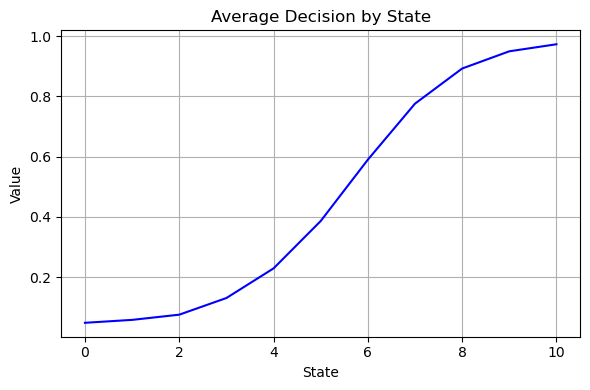

In [10]:
# Average decision for each xt
avg_decisions = df.groupby('State')['Decision'].mean()
print(avg_decisions)
plt.figure(figsize=(6, 4))  
plt.plot(avg_decisions, color='blue')
plt.title('Average Decision by State')
plt.xlabel('State')
plt.ylabel('Value')
plt.tight_layout()
plt.grid(True)
plt.show()

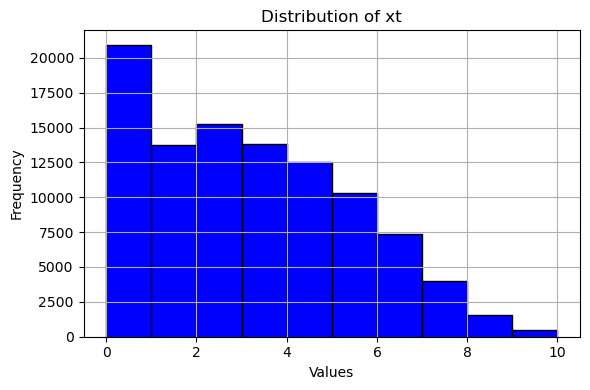

In [11]:
# Plot states
plt.figure(figsize=(6, 4))  
plt.hist(df['State'], color='blue', edgecolor='black')
plt.title('Distribution of xt')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.tight_layout()
plt.grid(True)
plt.show()

In [28]:
# Choice probability
def choice_prob(beta, params, tol, max_x, p_x):
    
    x = np.arange(max_x + 1, dtype=np.float64)
    
    V = value_function_iteration(beta, params, tol, max_x, p_x)
    v0 = u(x, 0, params) + beta * V
    v1 = u(x, 1, params) + beta * V[0]

    Pr_0 = 1 / (1 + np.exp(v1 - v0))
    Pr_1 = 1 - Pr_0

    return Pr_0, Pr_1

In [29]:
# Empirical probabilities
Pr_0, Pr_1 = choice_prob(beta, params, tol, max_x, p_x)
Pr_0, Pr_1

(array([0.95257413, 0.9435656 , 0.92026473, 0.87123136, 0.77639465,
        0.61719424, 0.41045996, 0.22059041, 0.09715623, 0.03624888,
        0.01174216]),
 array([0.04742587, 0.0564344 , 0.07973527, 0.12876864, 0.22360535,
        0.38280576, 0.58954004, 0.77940959, 0.90284377, 0.96375112,
        0.98825784]))

In [14]:
# Log-likelihood function
def log_like(df, beta, params, tol, max_x, p_x):
    logL = 0
    Pr_0, Pr_1 = choice_prob(beta, params, tol, max_x, p_x)
    
    for decision, state in zip(df.Decision, df.State):
        state = int(state)
        if decision == 0:
            logL += np.log(Pr_0[state])
        if decision == 1:
            logL += np.log(Pr_1[state])

    return -logL

In [15]:
# Log-likelihood value
ll = log_like(df, beta, params, tol, max_x, p_x)
ll

37984.07193849557

In [16]:
# Optimization function
def optimize_parameters(df, theta11, beta, tol, max_x, p_x):

    def objective(params):
        RC, theta11 = params
        return log_like(df, beta, params, tol, max_x, p_x)

    initial_guess = [0, 0]
    bounds = [[0, None], [0, None]]

    result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

    return result.x

In [17]:
# Bootstrap function
iterations = 100

def params_iteration(N, beta, tol, max_x, iterations, p_x):
    results = np.zeros((iterations, 2)) 
    
    for i in range(iterations):
        df1 = simulate_bus_operations(N, beta, RC, theta11, tol, max_x, p_x)
        optimized_params = optimize_parameters(df1, theta11, beta, tol, max_x, p_x)
        results[i, :] = optimized_params
    
    return results

In [18]:
# Bootstrap parameters
par = params_iteration(N, beta, tol, max_x, iterations, p_x)
param_df = pd.DataFrame(par, columns=['RC_', 'theta_'])
RC_u = param_df['RC_'].quantile(.975)
RC_l = param_df['RC_'].quantile(.025)
theta_u = param_df['theta_'].quantile(.975)
theta_l = param_df['theta_'].quantile(.025)

In [19]:
# SE function 
def standard_errors(params):
    se = np.std(params, axis=0)
    return se

se = standard_errors(par)

The real parameter is: 3
The mean for RC is: 3.000359881473707
The SE for RC is: 0.019528039045407893


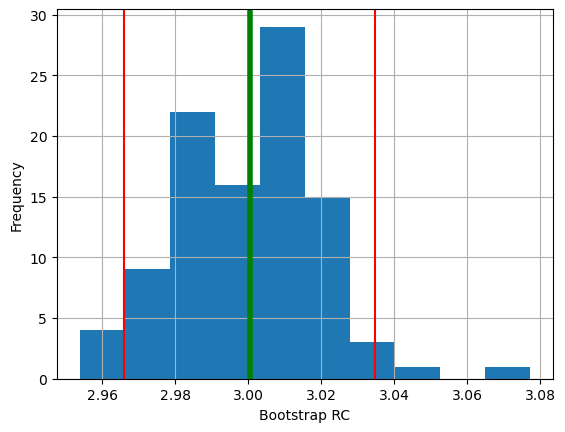

In [20]:
# RC_ 
param_df['RC_'].hist()
RC_mean = param_df['RC_'].mean()
print('The real parameter is:', RC)
print('The mean for RC is:', RC_mean)
print('The SE for RC is:', se[0])
plt.xlabel('Bootstrap RC')
plt.ylabel('Frequency')
plt.axvline(RC_u, color = 'red')
plt.axvline(RC_l, color = 'red')
plt.axvline(RC_mean, color = 'green', linewidth=4)

The real parameter is: 60
The mean for theta is: 60.00494351045405
The SE for theta is: 0.5651760557327454


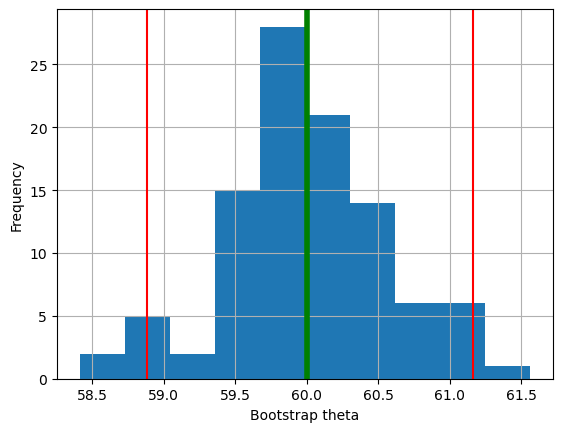

In [21]:
# theta_ 
param_df['theta_'].hist()
theta_mean = param_df['theta_'].mean()
print('The real parameter is:', theta11)
print('The mean for theta is:', theta_mean)
print('The SE for theta is:', se[1])
plt.xlabel('Bootstrap theta')
plt.ylabel('Frequency')
plt.axvline(theta_u, color = 'red')
plt.axvline(theta_l, color = 'red')
plt.axvline(theta_mean, color = 'green', linewidth=4)

In [22]:
# Save csv
df.to_csv('simulated_data.csv', index=False)

### Functions to define

In [8]:
# Inside conditional probability main function
def conditional_probability(df):
    cp1 = {}
    total_counts = df['State'].value_counts()
    for state in df['State'].unique():
        state_df = df[df['State'] == state]
        numerator = state_df[state_df['Decision'] == 1].shape[0]
        denominator = total_counts[state]
        if denominator != 0:
            cp1[state] = numerator / denominator
        else:
            cp1[state] = 0 

    return cp1

def complementary_probabilities(df):
    cp1 = conditional_probability(df)
    cp0 = {}
    for state, p in cp1.items():
        cp0[state] = 1 - p

    return cp0, cp1

In [9]:
# Conditional probabilities
def probabilities(df):  
        
    pc0 = complementary_probabilities(df)[0]
    pc1 = complementary_probabilities(df)[1]
    
    df_probs = pd.DataFrame({'State': list(pc1.keys()), 'P0': list(pc0.values()), 'P1': list(pc1.values())})
    df_probs = df_probs.sort_values('State').reset_index(drop=True)  
    
    return df_probs

In [10]:
# Conditional probabilities discrete approach
def probabilitiesCCP(df):
    
    pc0 = complementary_probabilities(df)[0]
    pc1 = complementary_probabilities(df)[1]
    
    df_probs = pd.DataFrame({'State': list(pc1.keys()), 'P0': list(pc0.values()), 'P1': list(pc1.values())})
    df_probs = df_probs.sort_values('State').reset_index(drop=True)  
    
    CCP = df_probs[['P0', 'P1']].to_numpy()
    
    return CCP

In [11]:
# Minimize
def distance_model_data(df, beta, params):
    df_probs = probabilities(df)
    phat_1 = df_probs['P1']
    phat_1 = np.array([phat_1])
    ptild_1 = est_choice_prob(df, beta, params)[1]

    diff = (phat_1 - ptild_1)**2
    diff = np.array([diff])
    mean = np.mean(diff)
    
    return mean

In [13]:
# SE function 
def standard_errors(params):
    se = np.std(params, axis=0)
    return se

### Hotz-Miller Approach

In [30]:
# Import simulated data
df = pd.read_csv('simulated_data.csv')

In [31]:
def value_function(df, beta, params):   
    def state_simulation(df, beta, params):
        df_probs = probabilities(df)
        max_x = 10
        p_x = 0.7
        gamma = 0.5772157
        threshold = 0.05
        betaV = []
        current_power = beta
        while current_power > threshold:
            betaV.append(current_power)
            current_power *= beta
        betaV = np.array(betaV)

        ### Decision 0
        df0 = pd.DataFrame()
        df0['State'] = range(11)
        df0['Decision'] = 0
        df0['P0'] = df_probs['P0']
        df0['P1'] = df_probs['P1']
        state_p_1 = np.minimum(df0['State'] + 1, max_x)
        state_p_2 = np.minimum(df0['State'] + 2, max_x)
        df0['State_prime'] = [
            np.random.choice([s1, s2], p=[p_x, (1 - p_x)]) 
            for s1, s2 in zip(state_p_1, state_p_2)
        ]
        df0['P0_prime'] = df0.apply(lambda row: df0.loc[df0['State'] == row['State_prime'], 'P0'].values[0], axis=1)
        df0['P1_prime'] = df0.apply(lambda row: df0.loc[df0['State'] == row['State_prime'], 'P1'].values[0], axis=1)
        df0['Decision_prime'] = [
            np.random.choice([0, 1], p=[p0, p1]) for p0, p1 in zip(df0['P0_prime'], df0['P1_prime'])
        ]

        # Adding state transition to State_prime_2
        state_p_1_prime = np.minimum(df0['State_prime'] + 1, max_x)
        state_p_2_prime = np.minimum(df0['State_prime'] + 2, max_x)
        df0['State_prime_2'] = np.where(df0['Decision_prime'] == 1, 0, [
            np.random.choice([s1, s2], p=[p_x, (1 - p_x)]) 
            for s1, s2 in zip(state_p_1_prime, state_p_2_prime)
        ])
        df0['P0_prime_2'] = df0.apply(lambda row: df0.loc[df0['State'] == row['State_prime_2'], 'P0'].values[0], axis=1)
        df0['P1_prime_2'] = df0.apply(lambda row: df0.loc[df0['State'] == row['State_prime_2'], 'P1'].values[0], axis=1)
        df0['Decision_prime_2'] = [
            np.random.choice([0, 1], p=[p0, p1]) for p0, p1 in zip(df0['P0_prime_2'], df0['P1_prime_2'])
        ]

        # Adding state transition to State_prime_3
        state_p_1_prime_2 = np.minimum(df0['State_prime_2'] + 1, max_x)
        state_p_2_prime_2 = np.minimum(df0['State_prime_2'] + 2, max_x)
        df0['State_prime_3'] = np.where(df0['Decision_prime'] == 1, 0, [
            np.random.choice([s1, s2], p=[p_x, (1 - p_x)]) 
            for s1, s2 in zip(state_p_1_prime_2, state_p_2_prime_2)
        ])
        df0['P0_prime_3'] = df0.apply(lambda row: df0.loc[df0['State'] == row['State_prime_3'], 'P0'].values[0], axis=1)
        df0['P1_prime_3'] = df0.apply(lambda row: df0.loc[df0['State'] == row['State_prime_3'], 'P1'].values[0], axis=1)
        df0['Decision_prime_3'] = [
            np.random.choice([0, 1], p=[p0, p1]) for p0, p1 in zip(df0['P0_prime_3'], df0['P1_prime_3'])
        ]

        # Adding state transition to State_prime_4
        state_p_1_prime_3 = np.minimum(df0['State_prime_3'] + 1, max_x)
        state_p_2_prime_3 = np.minimum(df0['State_prime_3'] + 2, max_x)
        df0['State_prime_4'] = np.where(df0['Decision_prime'] == 1, 0, [
            np.random.choice([s1, s2], p=[p_x, (1 - p_x)]) 
            for s1, s2 in zip(state_p_1_prime_3, state_p_2_prime_3)
        ])
        df0['P0_prime_4'] = df0.apply(lambda row: df0.loc[df0['State'] == row['State_prime_4'], 'P0'].values[0], axis=1)
        df0['P1_prime_4'] = df0.apply(lambda row: df0.loc[df0['State'] == row['State_prime_4'], 'P1'].values[0], axis=1)
        df0['Decision_prime_4'] = [
            np.random.choice([0, 1], p=[p0, p1]) for p0, p1 in zip(df0['P0_prime_4'], df0['P1_prime_4'])
        ]

        df0['u0t0'] = u(df0['State'], df0['Decision'], params)
        df0['u0t1'] = u(df0['State_prime'], df0['Decision_prime'], params)
        df0['u0t2'] = u(df0['State_prime_2'], df0['Decision_prime_2'], params)
        df0['u0t3'] = u(df0['State_prime_3'], df0['Decision_prime_3'], params)
        df0['u0t4'] = u(df0['State_prime_4'], df0['Decision_prime_4'], params)

        df0['v0'] = df0['u0t0'] + betaV[0] * (
            df0['u0t1'] + gamma - np.log(np.where(df0['Decision_prime'] == 0, df0['P0_prime'], df0['P1_prime']))
        ) + betaV[1] * (
            df0['u0t2'] + gamma - np.log(np.where(df0['Decision_prime_2'] == 0, df0['P0_prime_2'], df0['P1_prime_2']))
        ) + betaV[2] * (
            df0['u0t3'] + gamma - np.log(np.where(df0['Decision_prime_3'] == 0, df0['P0_prime_3'], df0['P1_prime_3']))
        ) + betaV[3] * (
            df0['u0t4'] + gamma - np.log(np.where(df0['Decision_prime_4'] == 0, df0['P0_prime_4'], df0['P1_prime_4']))
        ) 

        ### Decision 1
        df1 = pd.DataFrame()
        df1['State'] = range(11)
        df1['Decision'] = 1
        df1['P0'] = df_probs['P0']
        df1['P1'] = df_probs['P1']
        df1['State_prime'] = 0
        df1['P0_prime'] = df1['P0'][0]
        df1['P1_prime'] = df1['P1'][0]
        df1['Decision_prime'] = [
            np.random.choice([0, 1], p=[p0, p1]) for p0, p1 in zip(df1['P0_prime'], df1['P1_prime'])
        ]

        # Adding state transition to State_prime_2
        state_p_1_prime = np.minimum(df1['State_prime'] + 1, max_x)
        state_p_2_prime = np.minimum(df1['State_prime'] + 2, max_x)
        df1['State_prime_2'] = np.where(df1['Decision_prime'] == 1, 0, [
            np.random.choice([s1, s2], p=[p_x, (1 - p_x)]) 
            for s1, s2 in zip(state_p_1_prime, state_p_2_prime)
        ])
        df1['P0_prime_2'] = df1.apply(lambda row: df1.loc[df1['State'] == row['State_prime_2'], 'P0'].values[0], axis=1)
        df1['P1_prime_2'] = df1.apply(lambda row: df1.loc[df1['State'] == row['State_prime_2'], 'P1'].values[0], axis=1)
        df1['Decision_prime_2'] = [
            np.random.choice([0, 1], p=[p0, p1]) for p0, p1 in zip(df1['P0_prime_2'], df1['P1_prime_2'])
        ]

        # Adding state transition to State_prime_3
        state_p_1_prime_2 = np.minimum(df1['State_prime_2'] + 1, max_x)
        state_p_2_prime_2 = np.minimum(df1['State_prime_2'] + 2, max_x)
        df1['State_prime_3'] = np.where(df1['Decision_prime'] == 1, 0, [
            np.random.choice([s1, s2], p=[p_x, (1 - p_x)]) 
            for s1, s2 in zip(state_p_1_prime_2, state_p_2_prime_2)
        ])
        df1['P0_prime_3'] = df1.apply(lambda row: df1.loc[df1['State'] == row['State_prime_3'], 'P0'].values[0], axis=1)
        df1['P1_prime_3'] = df1.apply(lambda row: df1.loc[df1['State'] == row['State_prime_3'], 'P1'].values[0], axis=1)
        df1['Decision_prime_3'] = [
            np.random.choice([0, 1], p=[p0, p1]) for p0, p1 in zip(df1['P0_prime_3'], df1['P1_prime_3'])
        ]

        # Adding state transition to State_prime_4
        state_p_1_prime_3 = np.minimum(df1['State_prime_3'] + 1, max_x)
        state_p_2_prime_3 = np.minimum(df1['State_prime_3'] + 2, max_x)
        df1['State_prime_4'] = np.where(df1['Decision_prime'] == 1, 0, [
            np.random.choice([s1, s2], p=[p_x, (1 - p_x)]) 
            for s1, s2 in zip(state_p_1_prime_3, state_p_2_prime_3)
        ])
        df1['P0_prime_4'] = df1.apply(lambda row: df1.loc[df1['State'] == row['State_prime_4'], 'P0'].values[0], axis=1)
        df1['P1_prime_4'] = df1.apply(lambda row: df1.loc[df1['State'] == row['State_prime_4'], 'P1'].values[0], axis=1)
        df1['Decision_prime_4'] = [
            np.random.choice([0, 1], p=[p0, p1]) for p0, p1 in zip(df1['P0_prime_4'], df1['P1_prime_4'])
        ]

        df1['u1t0'] = u(df1['State'], df1['Decision'], params)
        df1['u1t1'] = u(df1['State_prime'], df1['Decision_prime'], params)
        df1['u1t2'] = u(df1['State_prime_2'], df1['Decision_prime_2'], params)
        df1['u1t3'] = u(df1['State_prime_3'], df1['Decision_prime_3'], params)
        df1['u1t4'] = u(df1['State_prime_4'], df1['Decision_prime_4'], params)

        df1['v1'] = df1['u1t0'] + betaV[0] * (
            df1['u1t1'] + gamma - np.log(np.where(df1['Decision_prime'] == 0, df1['P0_prime'], df1['P1_prime']))
        ) + betaV[1] * (
            df1['u1t2'] + gamma - np.log(np.where(df1['Decision_prime_2'] == 0, df1['P0_prime_2'], df1['P1_prime_2']))
        ) + betaV[2] * (
            df1['u1t3'] + gamma - np.log(np.where(df1['Decision_prime_3'] == 0, df1['P0_prime_3'], df1['P1_prime_3']))
        ) + betaV[3] * (
            df1['u1t4'] + gamma - np.log(np.where(df1['Decision_prime_4'] == 0, df1['P0_prime_4'], df1['P1_prime_4']))
        ) 

        return df0['v0'], df1['v1']
    
    def simulation(df, beta, params):
        np.random.seed(41)
        
        results = [state_simulation(df, beta, params) for _ in range(100)]
        v0_results = [result[0] for result in results]
        v1_results = [result[1] for result in results]
        v0_df = pd.DataFrame(v0_results)
        v1_df = pd.DataFrame(v1_results)
        v0_df = v0_df.T
        v1_df = v1_df.T
        mean0 = v0_df.mean(axis=1)
        mean1 = v1_df.mean(axis=1)
        
        return mean0, mean1
    
    mean0, mean1 = simulation(df, beta, params)
    mean0 = np.array([mean0])
    mean1 = np.array([mean1])
    
    return mean0, mean1

In [32]:
# Value Function
V = value_function(df, beta, params)
v0 = V[0]
v1 = V[1]
for i in v0, v1:
    v_hm = np.log(np.exp(v0) + np.exp(v1)) + 0.5772157
v_hm

array([[ 0.86829997,  0.56587541,  0.10028218, -0.3488988 , -0.8704173 ,
        -1.25771282, -1.51414   , -1.73693977, -1.86434413, -1.91978772,
        -1.9676792 ]])

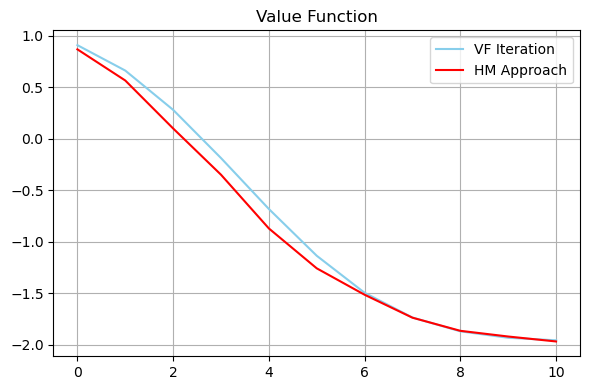

In [33]:
# Plot VF
plt.figure(figsize=(6, 4))  
plt.plot(VFI, color='skyblue', label='VF Iteration')
plt.plot(v_hm[0], color='red', label='HM Approach')
plt.title('Value Function')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [34]:
# Estimated choice probability
def est_choice_prob(df, beta, params):
    V = value_function(df, beta, params)
    v0 = V[0]
    v1 = V[1]

    P0 = 1 / (1 + np.exp(v1 - v0))
    P1 = 1 - P0

    return np.array([P0, P1])

In [35]:
# Empirical probabilities
phm0, phm1 = est_choice_prob(df, beta, params)
phm0, phm1

(array([[0.94110443, 0.92056426, 0.87397641, 0.80108965, 0.66285781,
         0.50496716, 0.36019932, 0.21032539, 0.09234833, 0.03622204,
         0.01254122]]),
 array([[0.05889557, 0.07943574, 0.12602359, 0.19891035, 0.33714219,
         0.49503284, 0.63980068, 0.78967461, 0.90765167, 0.96377796,
         0.98745878]]))

In [33]:
# Optimization function
def optimize_parameters(df, beta, params):

    def objective(params):
        RC, theta11 = params
        dist = distance_model_data(df, beta, params)
        return dist
    
    initial_guess = [0, 0]
    bounds = [[0, None], [0, None]]

    result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

    return result.x

In [34]:
# Bootstrap function
iterations = 100

def params_iteration(N, beta, tol, max_x, iterations, p_x):
    results = np.zeros((iterations, 2)) 
    
    for i in range(iterations):
        try:
            df1 = simulate_bus_operations(N, beta, RC, theta11, tol, max_x, p_x)
            optimized_params = optimize_parameters(df1, beta, params)
            results[i, :] = optimized_params
        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            results[i, :] = (0, 0)
        np.random.seed(i)
        #print(results)
    
    return results

In [35]:
# Bootstrap parameters
par = params_iteration(N, beta, tol, max_x, iterations, p_x)
param_df1 = pd.DataFrame(par, columns=['RC_', 'theta_'])

In [38]:
# SE function 
se1 = standard_errors(par)

The real parameter is: 3
The mean for RC is: 4.042252798200224
The SE for RC is: 0.0527554271504122


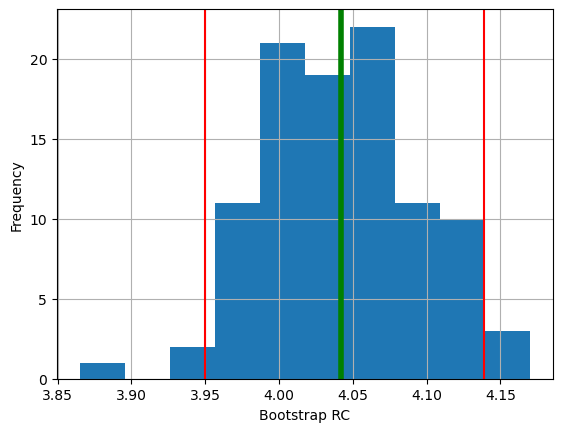

In [39]:
# RC_ 
RC_1 = param_df1[param_df1['RC_'] > 0]
RC_u1 = RC_1['RC_'].quantile(.975)
RC_l1 = RC_1['RC_'].quantile(.025)
RC_1['RC_'].hist()
RC_mean1 = RC_1['RC_'].mean()
print('The real parameter is:', RC)
print('The mean for RC is:', RC_mean1)
print('The SE for RC is:', se1[0])
plt.xlabel('Bootstrap RC')
plt.ylabel('Frequency')
plt.axvline(RC_u1, color = 'red')
plt.axvline(RC_l1, color = 'red')
plt.axvline(RC_mean1, color = 'green', linewidth=4)

The real parameter is: 60
The mean for theta is: 68.32909059272566
The SE for theta is: 1.0075042118013318


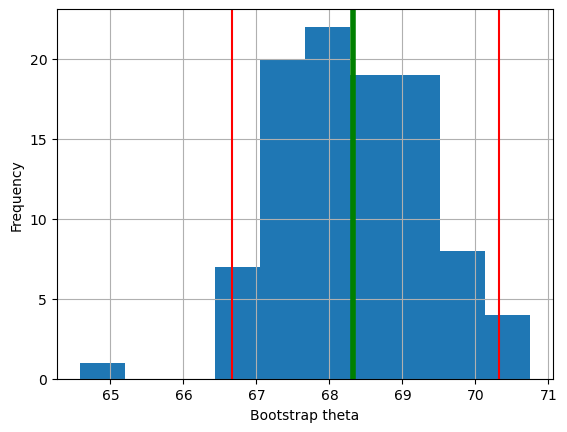

In [40]:
# theta_ 
theta1 = param_df1[param_df1['theta_'] > 0]
theta_u1 = theta1['theta_'].quantile(.975)
theta_l1 = theta1['theta_'].quantile(.025)
theta1['theta_'].hist()
theta_mean1 = theta1['theta_'].mean()
print('The real parameter is:', theta11)
print('The mean for theta is:', theta_mean1)
print('The SE for theta is:', se1[1])
plt.xlabel('Bootstrap theta')
plt.ylabel('Frequency')
plt.axvline(theta_u1, color = 'red')
plt.axvline(theta_l1, color = 'red')
plt.axvline(theta_mean1, color = 'green', linewidth=4)

### Hotz-Miller Inversion Approach

In [36]:
# Import simulated df
df = pd.read_csv('simulated_data.csv')

# Transition matrix
S = max_x + 1
t0 = create_transition_matrix(max_x, p_x)
t1 = np.zeros((S, S))
T = [t0, t1]

In [37]:
# Utility as an array
def utility(x, params):
    def c(x, theta):
        return -0.001 * theta * x**2
    
    RC, theta11 = params
    u0 = c((1 - 0) * x, theta11) - 0 * RC 
    u1 = c((1 - 1) * x, theta11) - 1 * RC 
    return u0, u1

# Inversion
def HM_inversion(df, params, T, beta):
    CCP = probabilitiesCCP(df)
    S = T[0].shape[0]  
    gamma = 0.5772157  
    I = np.identity(S)
    u_values = np.array([utility(x, params) for x in range(S)])  

    right = gamma + np.sum(CCP * (u_values - np.log(CCP)), axis=1)
    
    left = I - beta * (CCP[:, 0][:, np.newaxis] * T[0] + CCP[:, 1][:, np.newaxis] * T[1])
    EV = np.dot(np.linalg.inv(left), right)
    
    return EV.flatten()

In [38]:
# Value Function
v_i = HM_inversion(df, params, T, beta)
v_i

array([ 0.83669589,  0.56774243,  0.15348779, -0.36030249, -0.9115081 ,
       -1.42927496, -1.84973836, -2.13762479, -2.30017961, -2.37762443,
       -2.412212  ])

In [39]:
# P tilde
def P_tilde(df, params, T, beta):
    S = T[0].shape[0]
    EV = HM_inversion(df, params, T, beta)
    u_values = np.array([utility(x, params) for x in range(S)])
    E = np.exp(u_values + beta * np.column_stack((T[0] @ EV, T[1] @ EV)))
    ep1 = E[:, 1] / np.sum(E, axis=1)
    ep0 = 1 - ep1  
   
    return ep0.flatten(), ep1.flatten()

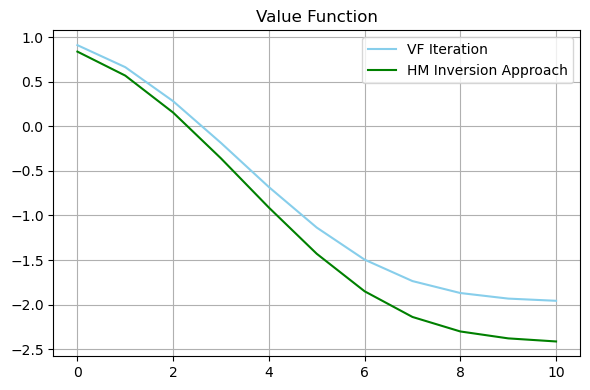

In [40]:
# Plot VF
plt.figure(figsize=(6, 4))  
plt.plot(VFI, color='skyblue', label='VF Iteration')
plt.plot(v_i, color='green', label='HM Inversion Approach')
plt.title('Value Function')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [41]:
# Display probabilities
pt0, pt1 = P_tilde(df, params, T, beta)
pt0, pt1

(array([0.96164399, 0.94977324, 0.92394304, 0.8728705 , 0.77942058,
        0.6299373 , 0.43703711, 0.24942028, 0.11567907, 0.0445272 ,
        0.01468542]),
 array([0.03835601, 0.05022676, 0.07605696, 0.1271295 , 0.22057942,
        0.3700627 , 0.56296289, 0.75057972, 0.88432093, 0.9554728 ,
        0.98531458]))

In [47]:
# Log-likelihood function
def log_like(df, params, T, beta):
    
    pt0, pt1 = P_tilde(df, params, T, beta)
    
    logL = 0

    for decision, state in zip(df['Decision'], df['State']):
        state = int(state)
        if decision == 0:
            logL += np.log(pt0[state])
        if decision == 1:
            logL += np.log(pt1[state])

    return -logL

In [48]:
# Display log-likelihood 
ll = log_like(df, params, T, beta)
ll

38043.65590209029

In [49]:
# Optimization function
def optimize_parameters(df, params, T, beta):

    def objective(params):
        RC, theta11 = params
        return log_like(df, params, T, beta)
    
    initial_guess = [0, 0]
    bounds = [[0, None], [0, None]]

    result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

    return result.x

In [50]:
# Bootstrap function
iterations = 100

def params_iteration(N, beta, tol, max_x, iterations, p_x):
    results = np.zeros((iterations, 2)) 
    
    for i in range(iterations):
        df1 = simulate_bus_operations(N, beta, RC, theta11, tol, max_x, p_x)
        optimized_params = optimize_parameters(df1, params, T, beta)
        results[i, :] = optimized_params
    
    return results

In [51]:
# Bootstrap parameters
par = params_iteration(N, beta, tol, max_x, iterations, p_x)
param_df2 = pd.DataFrame(par, columns=['RC_', 'theta_'])

In [52]:
# SE 
se2 = standard_errors(par)

The real parameter is: 3
The mean for RC is: 2.914567263740472
The SE for RC is: 1.42165667672325


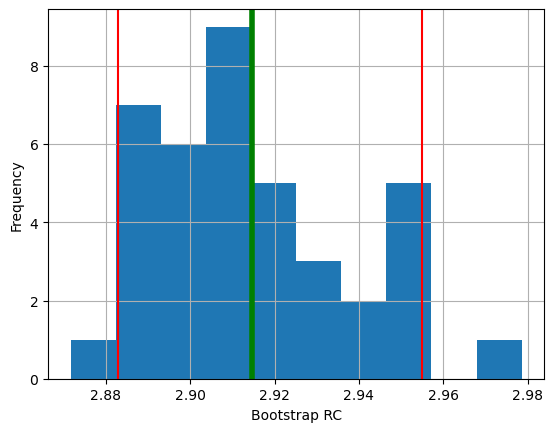

In [53]:
# RC_ 
RC_2 = param_df2[param_df2['RC_'] > 0]
RC_u2 = RC_2['RC_'].quantile(.975)
RC_l2 = RC_2['RC_'].quantile(.025)
RC_2['RC_'].hist()
RC_mean2 = RC_2['RC_'].mean()
print('The real parameter is:', RC)
print('The mean for RC is:', RC_mean2)
print('The SE for RC is:', se2[0])
plt.xlabel('Bootstrap RC')
plt.ylabel('Frequency')
plt.axvline(RC_u2, color = 'red')
plt.axvline(RC_l2, color = 'red')
plt.axvline(RC_mean2, color = 'green', linewidth=4)

The real parameter is: 60
The mean for theta is: 60.76622122298611
The SE for theta is: 29.640312888654517


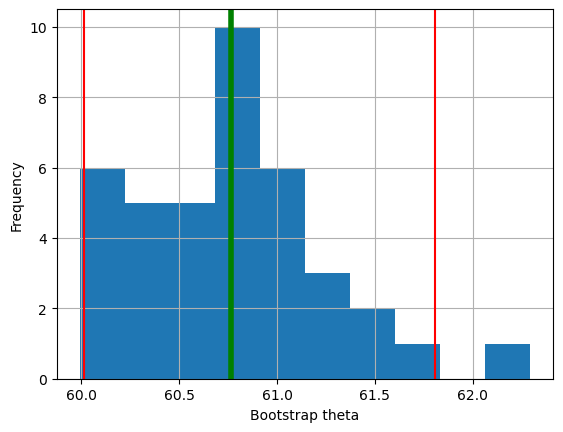

In [54]:
# theta_ 
theta2 = param_df2[param_df2['theta_'] > 0]
theta_u2 = theta2['theta_'].quantile(.975)
theta_l2 = theta2['theta_'].quantile(.025)
theta2['theta_'].hist()
theta_mean2 = theta2['theta_'].mean()
print('The real parameter is:', theta11)
print('The mean for theta is:', theta_mean2)
print('The SE for theta is:', se2[1])
plt.xlabel('Bootstrap theta')
plt.ylabel('Frequency')
plt.axvline(theta_u2, color = 'red')
plt.axvline(theta_l2, color = 'red')
plt.axvline(theta_mean2, color = 'green', linewidth=4)

### Arcidiacono and Ellickson Approach

In [42]:
# Import simulated df
df = pd.read_csv('simulated_data.csv')
df

,State,Decision,State_prime
0,0,0,2
1,2,0,3
2,3,0,4
3,4,0,5
4,5,0,6
...,...,...,...
99995,1,0,3
99996,3,0,4
99997,4,1,0
99998,0,0,2


In [43]:
def value_function(df, beta, params):   
    def state_simulation(df, beta, params):
        df_probs = probabilities(df)
        max_x = 10
        p_x = 0.7

        # Decision 0
        df0 = pd.DataFrame()
        df0['State'] = range(11)
        df0['Decision'] = 0
        df0['P0'] = df_probs['P0']
        df0['P1'] = df_probs['P1']
        state_p_1 = np.minimum(df0['State'] + 1, max_x)
        state_p_2 = np.minimum(df0['State'] + 2, max_x)
        df0['State_prime'] = [
            np.random.choice([s1, s2], p=[p_x, 1 - p_x]) for s1, s2 in zip(state_p_1, state_p_2)
        ]
        df0['P0_prime'] = df0.apply(lambda row: df0.loc[df0['State'] == row['State_prime'], 'P0'].values[0], axis=1)
        df0['P1_prime'] = df0.apply(lambda row: df0.loc[df0['State'] == row['State_prime'], 'P1'].values[0], axis=1)
        df0['Decision_prime'] = [
            np.random.choice([0, 1], p=[p0, p1]) for p0, p1 in zip(df0['P0_prime'], df0['P1_prime'])
        ]
        df0['u0t0'] = u(df0['State'], df0['Decision'], params)
        df0['u0t1'] = u(df0['State_prime'], df0['Decision_prime'], params)
        df0['v0'] = df0['u0t0'] + beta * (
            df0['u0t1'] - np.log(np.where(df0['Decision_prime'] == 0, df0['P0_prime'], 1))
        ) + beta * 0.5772157

        # Decision 1
        df1 = pd.DataFrame()
        df1['State'] = range(11)
        df1['Decision'] = 1
        df1['P0'] = df_probs['P0']
        df1['P1'] = df_probs['P1']
        df1['State_prime'] = 0
        df1['P0_prime'] = df1['P0'][0]
        df1['P1_prime'] = df1['P1'][0]
        df1['Decision_prime'] = [
            np.random.choice([0, 1], p=[p0, p1]) for p0, p1 in zip(df1['P0_prime'], df1['P1_prime'])
        ]
        df1['u1t0'] = u(df1['State'], df1['Decision'], params)
        df1['u1t1'] = u(df1['State_prime'], df1['Decision_prime'], params)
        df1['v1'] = df1['u1t0'] + beta * (
            df1['u1t1'] - np.log(np.where(df1['Decision_prime'] == 0, df1['P0_prime'], 1))
        ) + beta * 0.5772157

        return df0['v0'], df1['v1']
    
    def simulation(df, beta, params):
        np.random.seed(41)
        
        results = [state_simulation(df, beta, params) for _ in range(100)]
        v0_results = [result[0] for result in results]
        v1_results = [result[1] for result in results]
        v0_df = pd.DataFrame(v0_results)
        v1_df = pd.DataFrame(v1_results)
        v0_df = v0_df.T
        v1_df = v1_df.T
        mean0 = v0_df.mean(axis=1)
        mean1 = v1_df.mean(axis=1)
        
        return mean0, mean1
    
    mean0, mean1 = simulation(df, beta, params)
    mean0 = np.array([mean0])
    mean1 = np.array([mean1])
    
    return mean0, mean1

In [44]:
V = value_function(df, beta, params)
v0 = V[0]
v1 = V[1]
for i in v0, v1:
    v_a = np.log(np.exp(v0) + np.exp(v1)) + 0.5772157
v_a

array([[ 0.86210416,  0.57924138,  0.24694821, -0.22102373, -0.75200025,
        -1.25750894, -1.65014036, -2.00268892, -2.07157741, -2.11964397,
        -2.12848765]])

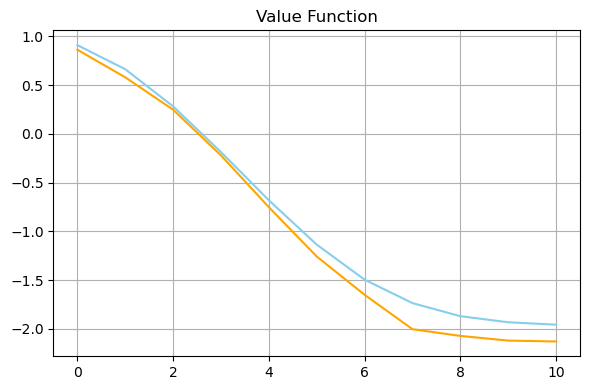

In [45]:
# Plot VF
plt.figure(figsize=(6, 4))  
plt.plot(VFI, color='skyblue', label='VF Iteration')
plt.plot(v_a[0], color='orange', label='Arcidiacono Approach')
plt.title('Value Function')
plt.tight_layout()
plt.grid(True)
plt.show()

In [46]:
# Estimated choice probability
def est_choice_prob(df, beta, params):
    V = value_function(df, beta, params)
    v0 = V[0]
    v1 = V[1]

    P0 = 1 / (1 + np.exp(v1 - v0))
    P1 = 1 - P0

    return np.array([P0, P1])

In [47]:
# Empirical probabilities
parc0, parc1 = est_choice_prob(df, beta, params)
parc0, parc1

(array([[0.95394958, 0.93505114, 0.90805933, 0.85541532, 0.75412043,
         0.57974956, 0.3776627 , 0.2162973 , 0.09388259, 0.03465497,
         0.01111367]]),
 array([[0.04605042, 0.06494886, 0.09194067, 0.14458468, 0.24587957,
         0.42025044, 0.6223373 , 0.7837027 , 0.90611741, 0.96534503,
         0.98888633]]))

In [20]:
# Optimization function
def optimize_parameters(df, beta, params):

    def objective(params):
        RC, theta11 = params
        dist = distance_model_data(df, beta, params)
        return dist
    
    initial_guess = [0, 0]
    bounds = [[0, None], [0, None]]

    result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

    return result.x

In [21]:
# Bootstrap function
iterations = 100

def params_iteration(N, beta, tol, max_x, iterations, p_x):
    results = np.zeros((iterations, 2)) 
    
    for i in range(iterations):
        try:
            df1 = simulate_bus_operations(N, beta, RC, theta11, tol, max_x, p_x)
            optimized_params = optimize_parameters(df1, beta, params)
            results[i, :] = optimized_params
        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            results[i, :] = (0, 0)
        np.random.seed(i)
        #print(results)
    
    return results

In [22]:
# Bootstrap parameters
par = params_iteration(N, beta, tol, max_x, iterations, p_x)
param_df3 = pd.DataFrame(par, columns=['RC_', 'theta_'])

In [23]:
# SE function 
se3 = standard_errors(par)

The real parameter is: 3
The mean for RC is: 3.1848526447802303
The SE for RC is: 0.025630458483426394


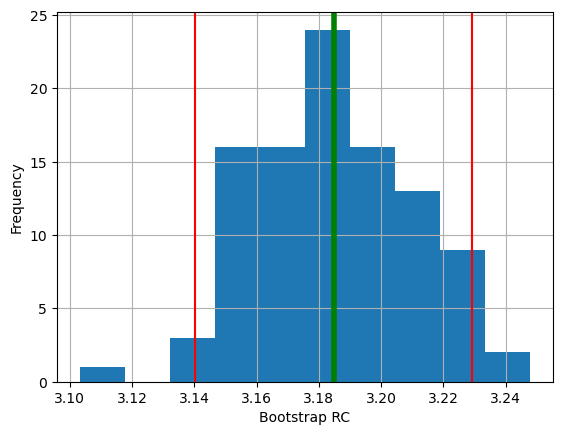

In [25]:
# RC_ 
RC_3 = param_df3[param_df3['RC_'] > 0]
RC_u3 = RC_3['RC_'].quantile(.975)
RC_l3 = RC_3['RC_'].quantile(.025)
RC_3['RC_'].hist()
RC_mean3 = RC_3['RC_'].mean()
print('The real parameter is:', RC)
print('The mean for RC is:', RC_mean3)
print('The SE for RC is:', se3[0])
plt.xlabel('Bootstrap RC')
plt.ylabel('Frequency')
plt.axvline(RC_u3, color = 'red')
plt.axvline(RC_l3, color = 'red')
plt.axvline(RC_mean3, color = 'green', linewidth=4)

The real parameter is: 60
The mean for theta is: 60.26466832957987
The SE for theta is: 0.6090118612181121


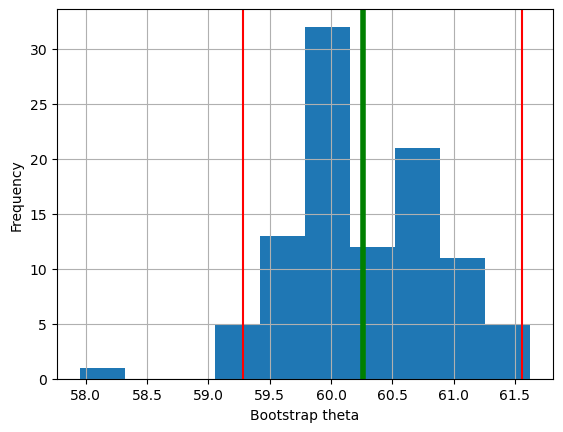

In [26]:
# theta_ 
theta3 = param_df3[param_df3['theta_'] > 0]
theta_u3 = theta3['theta_'].quantile(.975)
theta_l3 = theta3['theta_'].quantile(.025)
theta3['theta_'].hist()
theta_mean3 = theta3['theta_'].mean()
print('The real parameter is:', theta11)
print('The mean for theta is:', theta_mean3)
print('The SE for theta is:', se3[1])
plt.xlabel('Bootstrap theta')
plt.ylabel('Frequency')
plt.axvline(theta_u3, color = 'red')
plt.axvline(theta_l3, color = 'red')
plt.axvline(theta_mean3, color = 'green', linewidth=4)

### Compare Probabilities and VF

In [27]:
# Visualize df
prob = probabilities(df)
prob

,State,P0,P1
0,0,0.951204,0.048796
1,1,0.941514,0.058486
2,2,0.924250,0.075750
3,3,0.868992,0.131008
4,4,0.770657,0.229343
5,5,0.613537,0.386463
6,6,0.409978,0.590022
7,7,0.224125,0.775875
8,8,0.107541,0.892459
9,9,0.050398,0.949602


In [58]:
# Probabilities
pr = probabilities(df)
pr.rename(columns={'P0': 'phat0', 'P1': 'phat1'}, inplace=True)
pr['pt0_vf'] = Pr_0
pr['pt1_vf'] = Pr_1
pr['pt0_hm'] = phm0[0]
pr['pt1_hm'] = phm1[0]
pr['pt0_t'] = pt0
pr['pt1_t'] = pt1
pr['pt0_a'] = parc0[0]
pr['pt1_a'] = parc1[0]
pr = pr[['State', 'phat0', 'pt0_vf', 'pt0_hm', 'pt0_t', 'pt0_a', 'phat1', 'pt1_vf', 'pt1_hm', 'pt1_t', 'pt1_a']]

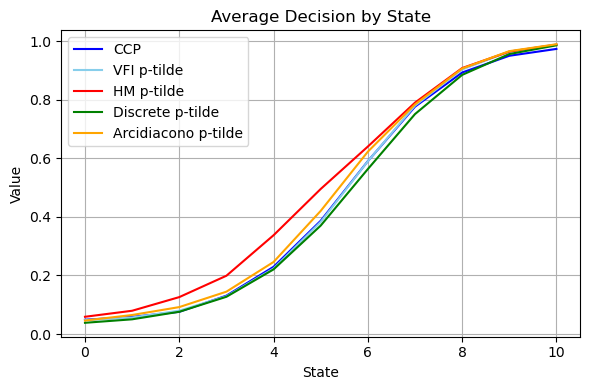

In [60]:
# Plot P1
plt.figure(figsize=(6, 4))  
plt.plot(pr['phat1'], color='blue', label='CCP')
plt.plot(pr['pt1_vf'], color='skyblue', label='VFI p-tilde')
plt.plot(pr['pt1_hm'], color='red', label='HM p-tilde')
plt.plot(pr['pt1_t'], color='green', label='Discrete p-tilde')
plt.plot(pr['pt1_a'], color='orange', label='Arcidiacono p-tilde')
plt.title('Average Decision by State')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend() 
plt.tight_layout()
plt.grid(True)
plt.show()

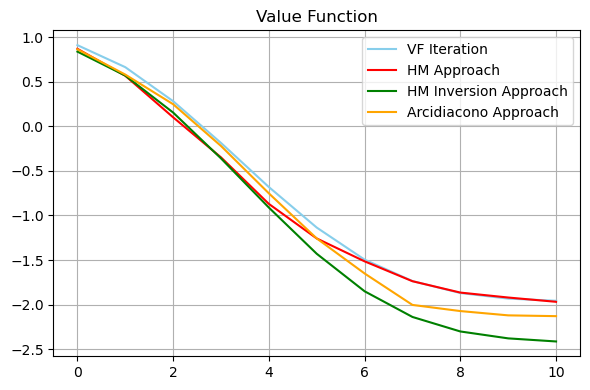

In [61]:
# Plot VF
plt.figure(figsize=(6, 4))  
plt.plot(VFI, color='skyblue', label='VF Iteration')
plt.plot(v_hm[0], color='red', label='HM Approach')
plt.plot(v_i, color='green', label='HM Inversion Approach')
plt.plot(v_a[0], color='orange', label='Arcidiacono Approach')
plt.title('Value Function')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()